In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import sklearn
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
import time

# Lab 10: Distributed Computing and Machine Learning

In this lab we are going to talk about two facinating topics-- 1) Distributed computing 2) machine learning. 

Distributed computing is becoming increasingly important because with the massive amout of data we have, it is becoming increasingly hard to get any knowledge using a single machine. However, using many computers we can distribute our work to many machines (nodes) and then we can reduce the result.



## MRJob: Parallel Computing with Python
### Simple word count example:

In [4]:
# MRJob
import os
mr_count = """
from mrjob.job import MRJob
import time


class MRWordFrequencyCount(MRJob):

    def mapper(self, _, line):
        yield "chars", len(line)
        yield "words", len(line.split())
        yield "lines", 1

    def reducer(self, key, values):
        yield key, sum(values)


if __name__ == '__main__':
    t1 = time.time()
    MRWordFrequencyCount.run()
    print "CPU Time", time.time() - t1"""

fout = open("mr_count.py","w")
fout.write(mr_count)
fout.close()
url = 'https://www.gutenberg.org/cache/epub/35/pg35.txt'

The code above made a python file on your computer and downloaded the novel time machine from Project Guttenberg. Now go to your terminal and run the code with

`python mr_count.py time_machine.txt`

In [5]:
complex_mr = """from mrjob.job import MRJob
import re
import time

WORD_RE = re.compile(r"[\w']+")


class MRMostUsedWord(MRJob):

    def mapper_get_words(self, _, line):
        # yield each word in the line
        for word in WORD_RE.findall(line):
            yield (word.lower(), 1)

    def combiner_count_words(self, word, counts):
        # sum the words we've seen so far
        yield (word, sum(counts))

    def reducer_count_words(self, word, counts):
        # send all (num_occurrences, word) pairs to the same reducer.
        # num_occurrences is so we can easily use Python's max() function.
        yield None, (sum(counts), word)

    # discard the key; it is just None
    def reducer_find_max_word(self, _, word_count_pairs):
        # each item of word_count_pairs is (count, word),
        # so yielding one results in key=counts, value=word
        yield max(word_count_pairs)

    def steps(self):
        return [
            self.mr(mapper=self.mapper_get_words,
                    combiner=self.combiner_count_words,
                    reducer=self.reducer_count_words),
            self.mr(reducer=self.reducer_find_max_word)
        ]


if __name__ == '__main__':
    t1 = time.time()
    MRMostUsedWord.run()
    print "CPU Time", time.time() - t1"""

fout = open("mr_max_count.py","w")
fout.write(complex_mr)
fout.close()

Execute the code with 

`python mr_max_count.py time_machine.txt`

### Should we always use map-reduce?!
Nobody ever got fired for using hadoop on a cluster! 
http://research.microsoft.com/pubs/163083/hotcbp12%20final.pdf

In [6]:
t1 = time.time()
fin = open("time_machine.txt","r")
lines = 0
words = 0
chars = 0

for l in fin:
    lines += 1
    words += len(l.split())
    chars += len(l)
    
print lines, words, chars
print "CPU Time", time.time() - t1

3617 35319 201900
CPU Time 0.00788712501526


As you can see MrJob did not perform as good as the single threaded implementation. Why?

The real benefit of using map-reduce becomes apparent when we have many computing nodes. For example, using amazon's server it is possible to perform this job on hundreds/thousands of nodes. 

Fun reading: http://open.blogs.nytimes.com/2007/11/01/self-service-prorated-super-computing-fun/

If you are interested in general local parallel computing, another library to play with is Multiprocessing: https://docs.python.org/2/library/multiprocessing.html

## Machine Learning: Fun with handwritten digits

In [7]:
# Clustering/ Parallelizing Clustering
from sklearn.datasets import load_digits
from sklearn.cross_validation import cross_val_score
from sklearn.ensemble import RandomForestClassifier

digits = load_digits()
print digits.data.shape

(1797, 64)


In [8]:
X = digits.data
y = digits.target

In [9]:
clf = RandomForestClassifier(n_estimators=50, random_state=0)

In [10]:
clf = clf.fit(X,y)

In [11]:
scores = cross_val_score(clf, X, y)

In [12]:
scores

array([ 0.92026578,  0.94490818,  0.93456376])

In [13]:
score_arr = []
for n in range(10,200,10):
    clf = RandomForestClassifier(n_estimators=n, random_state=0)
    clf = clf.fit(X,y)
    scores = cross_val_score(clf, X, y)
    score_arr.append(scores.mean() )
    

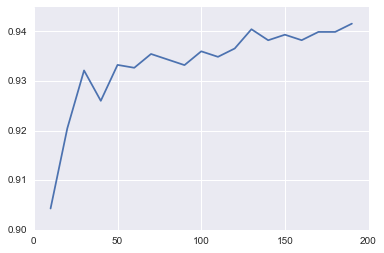

In [14]:
plt.plot(range(10,200,10), score_arr)